In [1]:
!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [2]:
!pip3 install -q "monai-weekly[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil,  openslide, pandas, einops, transformers, mlflow, matplotlib, tensorboardX, tifffile, imagecodecs]"

In [3]:
!pip3 install h5py
!python -c "import matplotlib" || pip install -q matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,

)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import matplotlib.pyplot as plt


from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized,  Compose
)
from monai.config import print_config
import re


In [5]:
from monai.config import print_config
print_config()

MONAI version: 0.9.dev2211
Numpy version: 1.21.5
Pytorch version: 1.10.2+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9c0d89cb7c774cba53242b9a3981fd02e75f3902
MONAI __file__: C:\Program Files\Python37\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.11.3+cu113
tqdm version: 4.63.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.17.0
mlflow version: 1.24.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
from monai.transforms import *

set_determinism(seed=0)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


In [7]:
data_dir = "D:\\dataSets\\CTORGmini\\"

train_images = sorted(
    glob.glob(os.path.join(data_dir, "volumes 0-49", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labels", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
data_dicts

[{'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-0.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-0.nii.gz'},
 {'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-1.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-1.nii.gz'},
 {'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-2.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-2.nii.gz'},
 {'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-3.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-3.nii.gz'}]

In [8]:
# stringss = ["CCA - L SUV, CCA - R SUV", " frontal lobe R SUV", " frontal lobe L SUV", " temporal lobe R SUV",
#             " temporal lobe L SUV", " parietal lobe R SUV"
#     , " parietal lobe L SUV", " occipital lobe R SUV", " occipital lobe L SUV", " cerebellum R SUV",
#             " cerebellum L SUV",
#             " CCA - L description", " L ICA flow speed", " L ICA constriction%", " L ECA flow speed",
#             " L ECA constriction%"
#     , " CCA - R description", " RICA flow speed", " RICA constriction%", " ECA flow speed", " ECA constriction%",
#             " left verterbral artery", " right verterbral artery"
#     , " Neurologic Examination", " Other Signs", " hypertension", " Surgery", " other diseases", " diabetes",
#             " nicotinism"]
# for str in stringss:
#     print("MERGE " + "(:Var {name : ' " + str + "'})  ")

In [9]:
def getNumberFromFilePath(dat):
    string = str(dat['image_meta_dict']['filename_or_obj'])
    numb = re.search('.nii', string).span()[0] ## this does what you wanted
    describingNumber = string[(numb-3):(numb)].replace("-","").replace("e","")
    return int(describingNumber)

In [10]:
import h5py
f = h5py.File("D:\\dataSets\\forMainHDF5\\smallLiverDataSet.hdf5", "w")

image shape: torch.Size([348, 250, 371]), label shape: torch.Size([348, 250, 371])


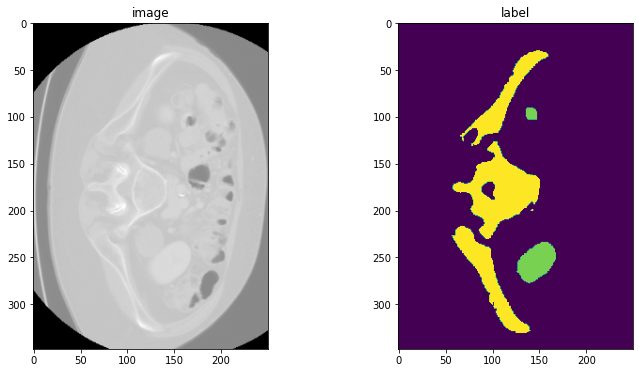

image shape: torch.Size([346, 299, 611]), label shape: torch.Size([346, 299, 611])


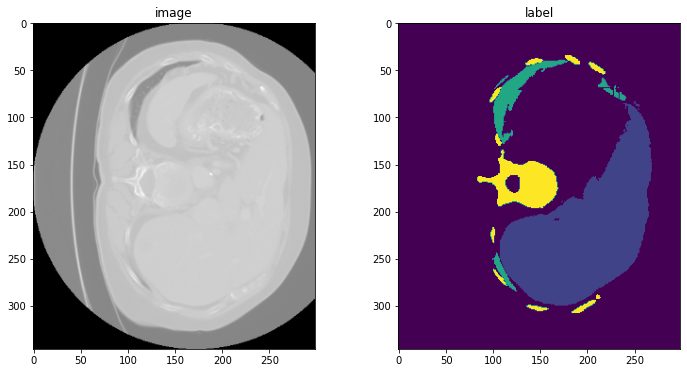

image shape: torch.Size([397, 358, 517]), label shape: torch.Size([397, 358, 517])


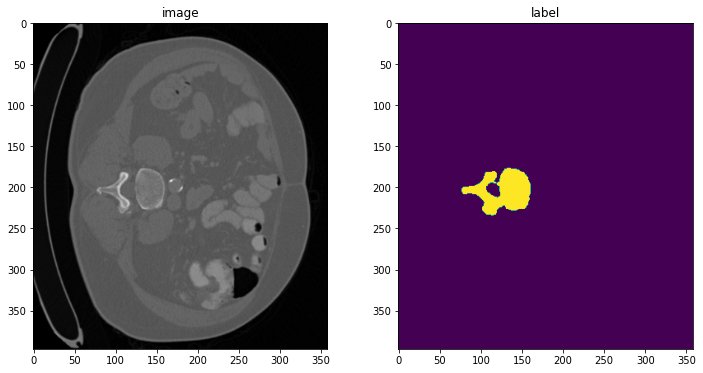

image shape: torch.Size([355, 349, 534]), label shape: torch.Size([355, 349, 534])


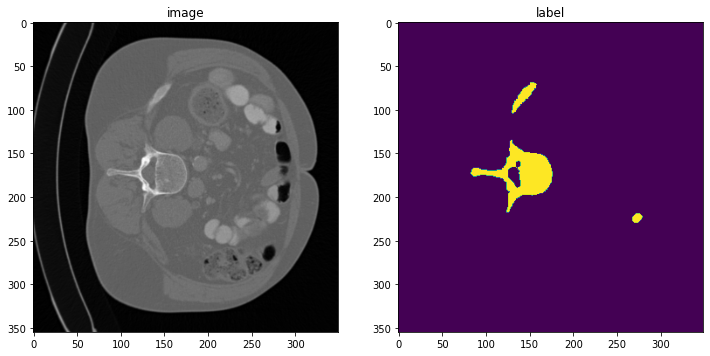

In [11]:
check_ds = Dataset(data=data_dicts, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for dat in check_loader:
    image= dat['image'][0,0,:,:]
    label=  dat['label'][0,0,:,:]
    middleSlice = round(label.size()[2]/2)
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, middleSlice], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, middleSlice])
    plt.show()


In [12]:
check_ds = Dataset(data=data_dicts, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

for dat in check_loader:
    describingNumber = getNumberFromFilePath(dat)
    grp = f.create_group(str(describingNumber))

    labelBoolTensor =torch.where( dat['label']==1, 1, 0).bool()
    summ= torch.sum(labelBoolTensor)
    #if summ>0:
    labelBoolDataset = grp.create_dataset('liver', data=  (labelBoolTensor).detach().numpy())
    imageDataset = grp.create_dataset('image', data=  (dat['image']).detach().numpy())
    labelBoolDataset.attrs['sum']=  summ
    
    imageDataset.attrs['dataType']=  "CT"
    labelBoolDataset.attrs['dataType']=  "boolLabel"

    #seting spacing - needs to be the same for all of the arrays in a grop - so the same for all images in patient
    grp.attrs['spacing']=(1,1,1)

    #get minimum and maximum values
    imageDataset.attrs['min']=torch.min(dat['image'])
    imageDataset.attrs['max']=torch.max(dat['image'])

    labelBoolDataset.attrs['min']=0
    labelBoolDataset.attrs['max']=1

  

    print(describingNumber)
    pass

0
1
2
3


In [13]:
f.close()

In [14]:
# filename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\volumes 0-49\\volume-21.nii.gz"
# biggestDat, meta = LoadImage()(filename)
# labelFilename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\labels\\labels-21.nii.gz"
# biggestDatLabel, metaLabel = LoadImage()(labelFilename)
# biggestDatLabel


# image, label = (biggestDat[:,:,:], biggestDatLabel[:,:,:])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 500], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 500])
# plt.show()
# # torch.Size([544, 419, 1720])